In [1]:
from IPython.display import display
from IPython.display import clear_output

from imutils.video import VideoStream
import imutils

import time
import numpy as np
import cv2
import IPython
import io

from edgetpu.detection.engine import DetectionEngine
from PIL import Image
from PIL import ImageDraw

%matplotlib inline
import matplotlib.pyplot as plt

from time import sleep
import multiprocessing as mp

In [2]:
processes = []
frameBuffer = None
results = None

In [3]:
def showarray(a, fmt='jpeg'):
    f = io.BytesIO()
    #Image.fromarray(a).save(f, fmt)
    a.save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [4]:
# Function to read labels from text files.
def ReadLabelFile(file_path):
  with open(file_path, 'r') as f:
    lines = f.readlines()
  ret = {}
  for line in lines:
    pair = line.strip().split(maxsplit=1)
    ret[int(pair[0])] = pair[1].strip()
  return ret

In [5]:
def camThread(label, results, frameBuffer):

    camera_width = 320
    camera_height = 240
    vidfps = 30

    cam = cv2.VideoCapture(0)
    #cam = cv2.VideoCapture(get_camerasrc(0), cv2.CAP_GSTREAMER)

    #cam.set(cv2.CAP_PROP_FPS, vidfps)
    #cam.set(cv2.CAP_PROP_FRAME_WIDTH, camera_width)
    #cam.set(cv2.CAP_PROP_FRAME_HEIGHT, camera_height)

    #cam = cv2.VideoCapture('rkisp device=/dev/video1 io-mode=4 path-iqf=/etc/cam_iq/ov13850.xml ! video/x-raw,format=NV12,width=740 ,height=360,framerate=30/1 ! videoconvert ! appsink', cv2.CAP_GSTREAMER)


    while True:
        try:
            t1 = time.perf_counter()

            ret, color_image = cam.read()
            if not ret:
                print("no image")
                continue
            if frameBuffer.full():
                frameBuffer.get()
            frames = color_image
            frameBuffer.put(color_image.copy())
            res = None
        except BaseException as e: 
            print("Exiting")
            print(e)
        except (KeyboardInterrupt, SystemExit):
            print("Camera release")
            cam.release() 
            break
            


In [6]:


def inferencer(results, frameBuffer, labels):

    #engine = DetectionEngine(model)
    print("Hello!!!!")
    engine = DetectionEngine('/home/mendel/TPU-MobilenetSSD/mobilenet_ssd_v2_coco_quant_postprocess_edgetpu.tflite')
    
    while True:

        if frameBuffer.empty():
            continue
       
        # Run inference.
        color_image = frameBuffer.get()
        prepimg = color_image[:, :, ::-1].copy()
        prepimg = Image.fromarray(prepimg)
        draw = ImageDraw.Draw(prepimg)
        tinf = time.perf_counter()
        #print("Hello detect !!!!")
        t1 = time.time()
        out = engine.DetectWithImage(prepimg, threshold=0.5, keep_aspect_ratio=True, relative_coord=False, top_k=10)
        if out:
            for obj in out:
                #print ('-----------------------------------------')
                #if labels:
                #    print(labels[obj.label_id])
                #print ('score = ', obj.score)
                box = obj.bounding_box.flatten().tolist()
                #print ('box = ', box)
                # Draw a rectangle.
                draw.rectangle(box, outline='red')
                if labels:
                    draw.text((box[0] + (box[2]-box[0]), box[1]), labels[obj.label_id] , fill='green')
            
        t2 = time.time()
        fps = 1/(t2-t1)
        fps_str = 'FPS = %.2f' % fps
        draw.text((10,220), fps_str , fill='green')
        #imcv = np.asarray(prepimg)[:,:,::-1].copy()
        #if results.full():
        #    results.get()
        #results = color_image
        #results.put(imcv)
        
        showarray(prepimg)
        clear_output(wait=True)
        #print("Hello detect !!!!")
        #print(time.perf_counter() - tinf, "sec")
        #results.put(ans)

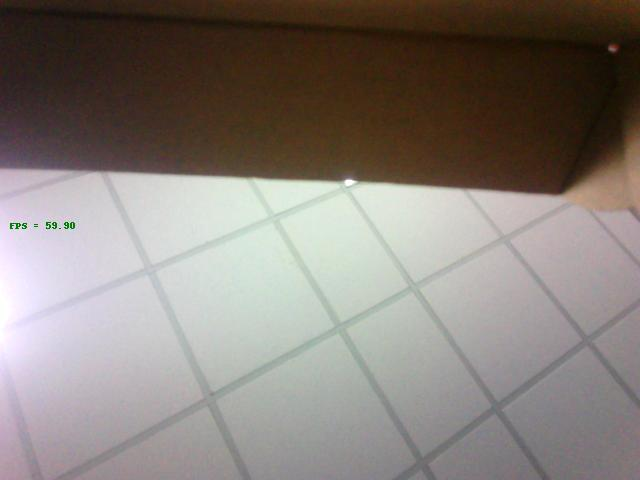

Process Process-2:


KeyboardInterrupt: 

In [7]:
# Initialize engine.
labels = ReadLabelFile('/home/mendel/TPU-MobilenetSSD/coco_labels.txt') 
# Run inference.


try:
    frameBuffer = mp.Queue(10)
    results = mp.Queue(10)

    # Start streaming
    p = mp.Process(target=camThread, args=(labels, results, frameBuffer), daemon=True)
    p.start()
    processes.append(p)


    # Activation of inferencer
    p = mp.Process(target=inferencer, args=(results, frameBuffer, labels), daemon=True)
    p.start()
    processes.append(p)
    
    

    """GObject.threads_init()
    Gst.init(None)

    server = GstServer(buffer1=results)

    loop = GObject.MainLoop()
    loop.run()"""

    while True:
        sleep(1)

finally:
    for p in range(len(processes)):
        processes[p].terminate()


In [ ]:
import utils.inference as inference_utils